<a href="https://colab.research.google.com/github/Richardjmorton/colab/blob/master/Pyro_examples.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip3 install pyro-ppl 

     |████████████████████████████████| 678 kB 7.3 MB/s 


In [ ]:
import torch

import pyro
import pyro.distributions as dist
import pyro.infer as infer
import pyro.optim as optim

import numpy as np

import matplotlib.pyplot as plt

In [ ]:
pyro.set_rng_seed(101)

In [ ]:
loc = 0.   # mean zero
scale = 1. # unit variance
normal = dist.Normal(loc, scale) # create a normal distribution object
x = normal.rsample(sample_shape=(1, 1000)) # draw a sample from N(0,1)

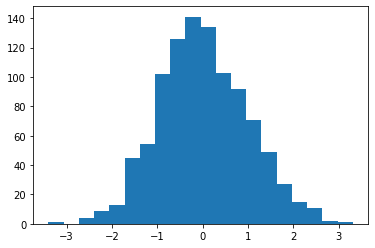

In [ ]:
plt.hist(x, bins='scott');

In [ ]:
def weather():
    cloudy = pyro.sample('cloudy', dist.Bernoulli(0.3))
    cloudy = 'cloudy' if cloudy.item() == 1.0 else 'sunny'
    mean_temp = {'cloudy': 55.0, 'sunny': 75.0}[cloudy]
    scale_temp = {'cloudy': 10.0, 'sunny': 15.0}[cloudy]
    temp = pyro.sample('temp', dist.Normal(mean_temp, scale_temp))
    return cloudy, temp.item()

for _ in range(3):
    print(weather())

('cloudy', 45.44039535522461)
('sunny', 60.92064666748047)
('sunny', 67.25375366210938)


In [ ]:
cloudy = dist.Bernoulli(0.3).sample(sample_shape=(1, 10))

In [ ]:
cloudy.item()

ValueError: ignored

In [ ]:
def scale(guess):
    weight = pyro.sample("weight", dist.Normal(guess, 1.0))
    return pyro.sample("measurement", dist.Normal(weight, 0.75))

In [ ]:
conditioned_scale = pyro.condition(scale, data={"measurement": torch.tensor([9.5])})

In [ ]:
from torch.distributions import constraints

def scale_parametrized_guide(guess):
    a = pyro.param("a", torch.tensor(guess))
    b = pyro.param("b", torch.tensor(1.), constraint=constraints.positive)
    return pyro.sample("weight", dist.Normal(a, b))

In [ ]:
guess = 8.5

pyro.clear_param_store()
svi = pyro.infer.SVI(model=conditioned_scale,
                     guide=scale_parametrized_guide,
                     optim=pyro.optim.Adam({"lr": 0.003}),
                     loss=pyro.infer.Trace_ELBO())

a =  9.146610260009766
b =  0.6111319661140442


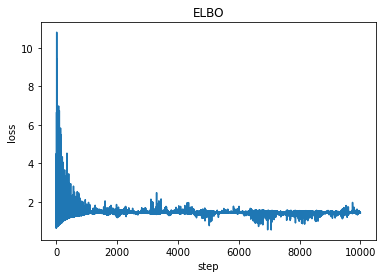

In [ ]:
pyro.clear_param_store()
losses, a, b = [], [], []
num_steps = 10000
for t in range(num_steps):
    losses.append(svi.step(guess))
    a.append(pyro.param("a").item())
    b.append(pyro.param("b").item())

plt.plot(losses)
plt.title("ELBO")
plt.xlabel("step")
plt.ylabel("loss");
print('a = ',pyro.param("a").item())
print('b = ', pyro.param("b").item())

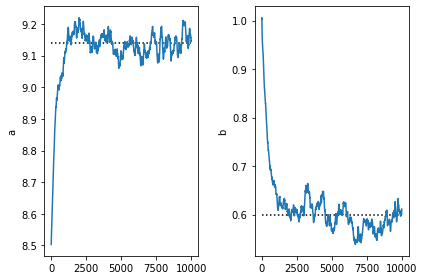

In [ ]:
plt.subplot(1,2,1)
plt.plot([0,num_steps],[9.14,9.14], 'k:')
plt.plot(a)
plt.ylabel('a')

plt.subplot(1,2,2)
plt.ylabel('b')
plt.plot([0,num_steps],[0.6,0.6], 'k:')
plt.plot(b)
plt.tight_layout()

# Bernoulli Example

In [ ]:
# create some data with 6 observed heads and 4 observed tails
data = torch.zeros(10)
data[0:6] = torch.ones(6)  # 6 heads and 4 tails

In [ ]:
def model(data):
    # define the hyperparameters that control the beta prior
    alpha0 = torch.tensor(10.0)
    beta0 = torch.tensor(10.0)
    # sample f from the beta prior
    f = pyro.sample("latent_fairness", dist.Beta(alpha0, beta0))
    # loop over the observed data
    with pyro.plate('observe_data'):
        pyro.sample('obs', dist.Bernoulli(f), obs=data)
    # for i in range(len(data)):
    #     # observe datapoint i using the bernoulli
    #     # likelihood Bernoulli(f)
    #     pyro.sample("obs_{}".format(i), dist.Bernoulli(f), obs=data[i])


In [ ]:
def guide(data):
    # register the two variational parameters with Pyro.
    alpha_q = pyro.param("alpha_q", torch.tensor(15.0),
                         constraint=constraints.positive)
    beta_q = pyro.param("beta_q", torch.tensor(15.0),
                        constraint=constraints.positive)
    # sample latent_fairness from the distribution Beta(alpha_q, beta_q)
    pyro.sample("latent_fairness", dist.Beta(alpha_q, beta_q))

In [ ]:
# set up the optimizer
from pyro.optim import Adam
from pyro.infer import SVI, Trace_ELBO
import torch.distributions.constraints as constraints


# clear the param store in case we're in a REPL
pyro.clear_param_store()

adam_params = {"lr": 0.0005, "betas": (0.90, 0.999)}
optimizer = Adam(adam_params)

# setup the inference algorithm
svi = SVI(model, guide, optimizer, loss=Trace_ELBO())

n_steps = 5000
# do gradient steps
losses, alpha_q, beta_q = [], [], []
for step in range(n_steps):
    losses.append(svi.step(data))
    alpha_q.append(pyro.param("alpha_q").item())
    beta_q.append(pyro.param("beta_q").item())
 
alpha_q = np.asarray(alpha_q)
beta_q = np.asarray(beta_q)

In [ ]:
# here we use some facts about the beta distribution
# compute the inferred mean of the coin's fairness
inferred_mean = alpha_q / (alpha_q + beta_q)
# compute inferred standard deviation
factor = beta_q / (alpha_q * (1.0 + alpha_q + beta_q))
inferred_std = inferred_mean * np.sqrt(factor)

print("\nbased on the data and our prior belief, the fairness " +
      "of the coin is %.3f +- %.3f" % (inferred_mean[-1], inferred_std[-1]))


based on the data and our prior belief, the fairness of the coin is 0.524 +- 0.090


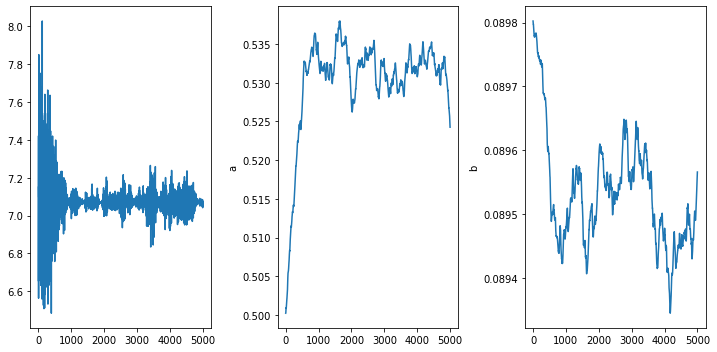

In [ ]:
plt.figure(figsize=(10,5))
plt.subplot(1,3,1)
plt.plot(elbo_loss)

plt.subplot(1,3,2)
plt.plot(inferred_mean)
plt.ylabel('a')

plt.subplot(1,3,3)
plt.ylabel('b')
plt.plot(inferred_std)
plt.tight_layout()

In [ ]:
?pyro.plate